In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import glob
import math
import progressbar

In [ ]:
# Image visualization

def plot_images(images, num_images=5):
    # Select random images
    indices = np.random.choice(images.shape[0], num_images, replace=False)
    selected_images = images[indices]
    
    # Plot as 3-channel images
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[0,i].imshow(selected_images[i])
        axes[0,i].axis('off')
        if i == 0:
            axes[0,i].set_title('3-Channel Image')
    
    # Plot as single-channel images
    single_channel_images = selected_images[:, :, :, 0]
    for i in range(num_images):
        axes[1,i].imshow(single_channel_images[i])
        axes[1,i].axis('off')
        if i == 0:
            axes[1,i].set_title('Single-Channel Image')
    
    plt.show()

In [ ]:
# Calculating PSNR 
def psnr(original_image, reconstructed_image):
    mse = torch.mean((original_image - reconstructed_image) ** 2)
    max_pixel = torch.max(original_image)
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

In [ ]:

class Autoencoder_low(nn.Module):
    def __init__(self):
        super(Autoencoder_low, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64))
        

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
### LOADING LOW RES DATA

# Directory containing the npz files
low_dir_path = '/content/drive/MyDrive/Colab Notebooks/data/low2'

# Search for all npz files in the directory
low_npz_files = glob.glob(f'{low_dir_path}/*.npz')

# Load images from all npz files
low_images_list = []
for npz_file in progressbar.progressbar(low_npz_files):
  low_dataset = np.load(npz_file)
  low_images = low_dataset['image_data']

  # Normalize each channel between 0 and 1
  low_images_norm = np.zeros_like(low_images)
  for i in range(3):
    low_images_norm[:, :, :, i] = (low_images[:, :, :, i] - low_images[:, :, :, i].min()) / (low_images[:, :, :, i].max() - low_images[:, :, :, i].min())

  low_images_list.append(low_images_norm)

# Concatenate images from all npz files into a single numpy array
images = np.concatenate(low_images_list, axis=0)

100% (125 of 125) |######################| Elapsed Time: 0:00:08 Time:  0:00:08


In [ ]:
# Split the data into training, validation, and testing sets
x_train, x_test = train_test_split(images, test_size=0.2)
x_train, x_val = train_test_split(x_train, test_size=0.2)

print(f"No. of training examples: {x_train.shape[0]}")
print(f"No. of validation examples: {x_val.shape[0]}")
print(f"No. of testing examples: {x_test.shape[0]}")

# Convert the data to PyTorch tensors and create datasets
train_tensor_x = torch.cuda.FloatTensor(x_train) 
val_tensor_x = torch.cuda.FloatTensor(x_val)
test_tensor_x = torch.cuda.FloatTensor(x_test)

my_train_dataset = TensorDataset(train_tensor_x, train_tensor_x)
my_val_dataset = TensorDataset(val_tensor_x, val_tensor_x)
my_test_dataset = TensorDataset(test_tensor_x, test_tensor_x)

# Define the data loaders
train_loader = DataLoader(my_train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(my_val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(my_test_dataset, batch_size=256, shuffle=False)



No. of training examples: 16000
No. of validation examples: 4000
No. of testing examples: 5000


Displaying sample images from dataset

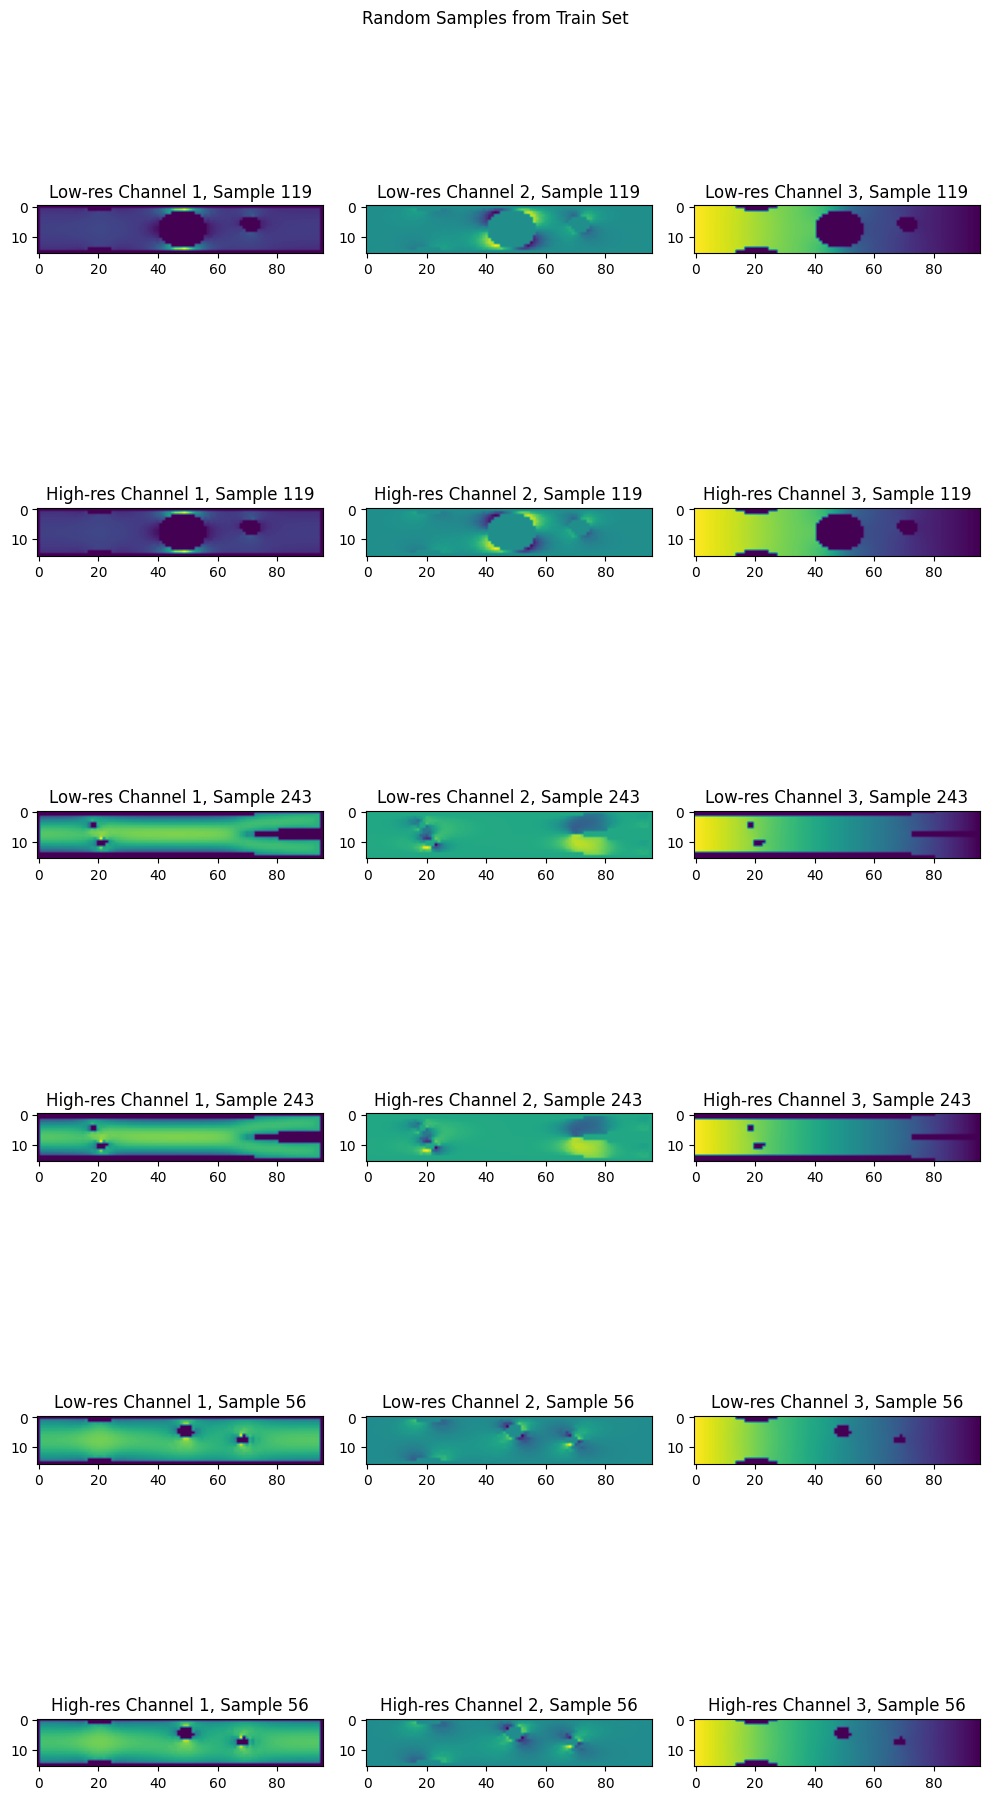

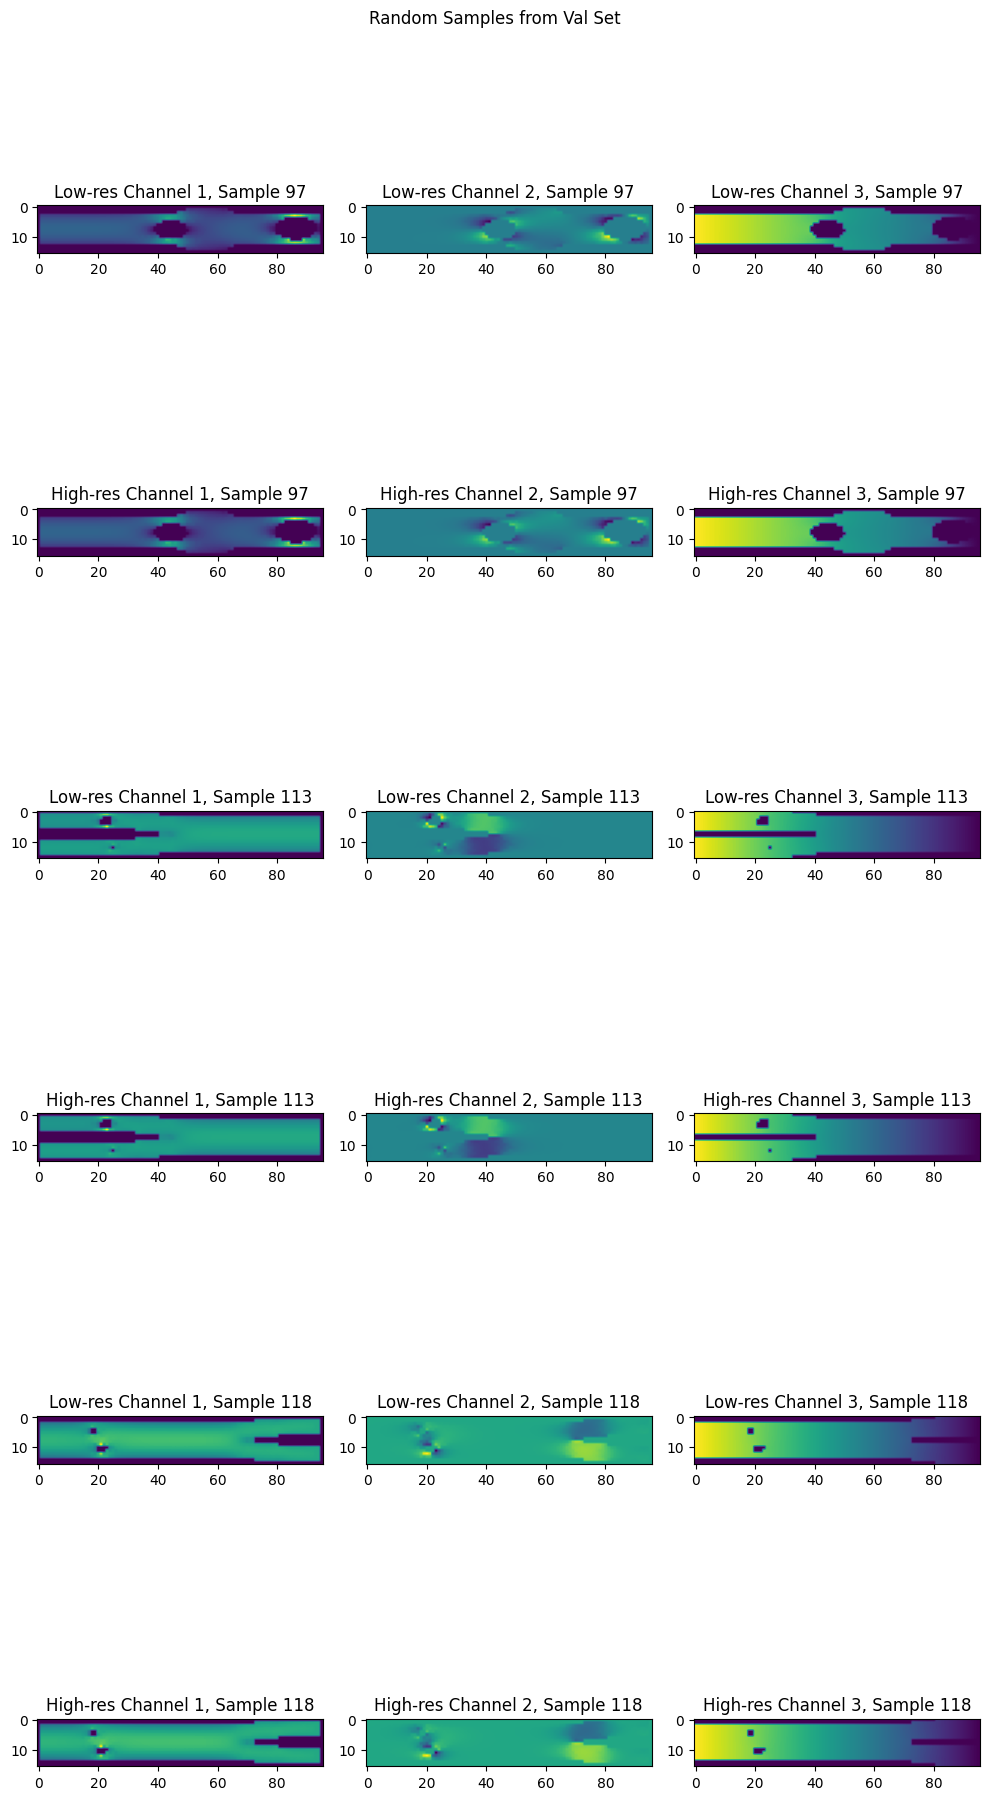

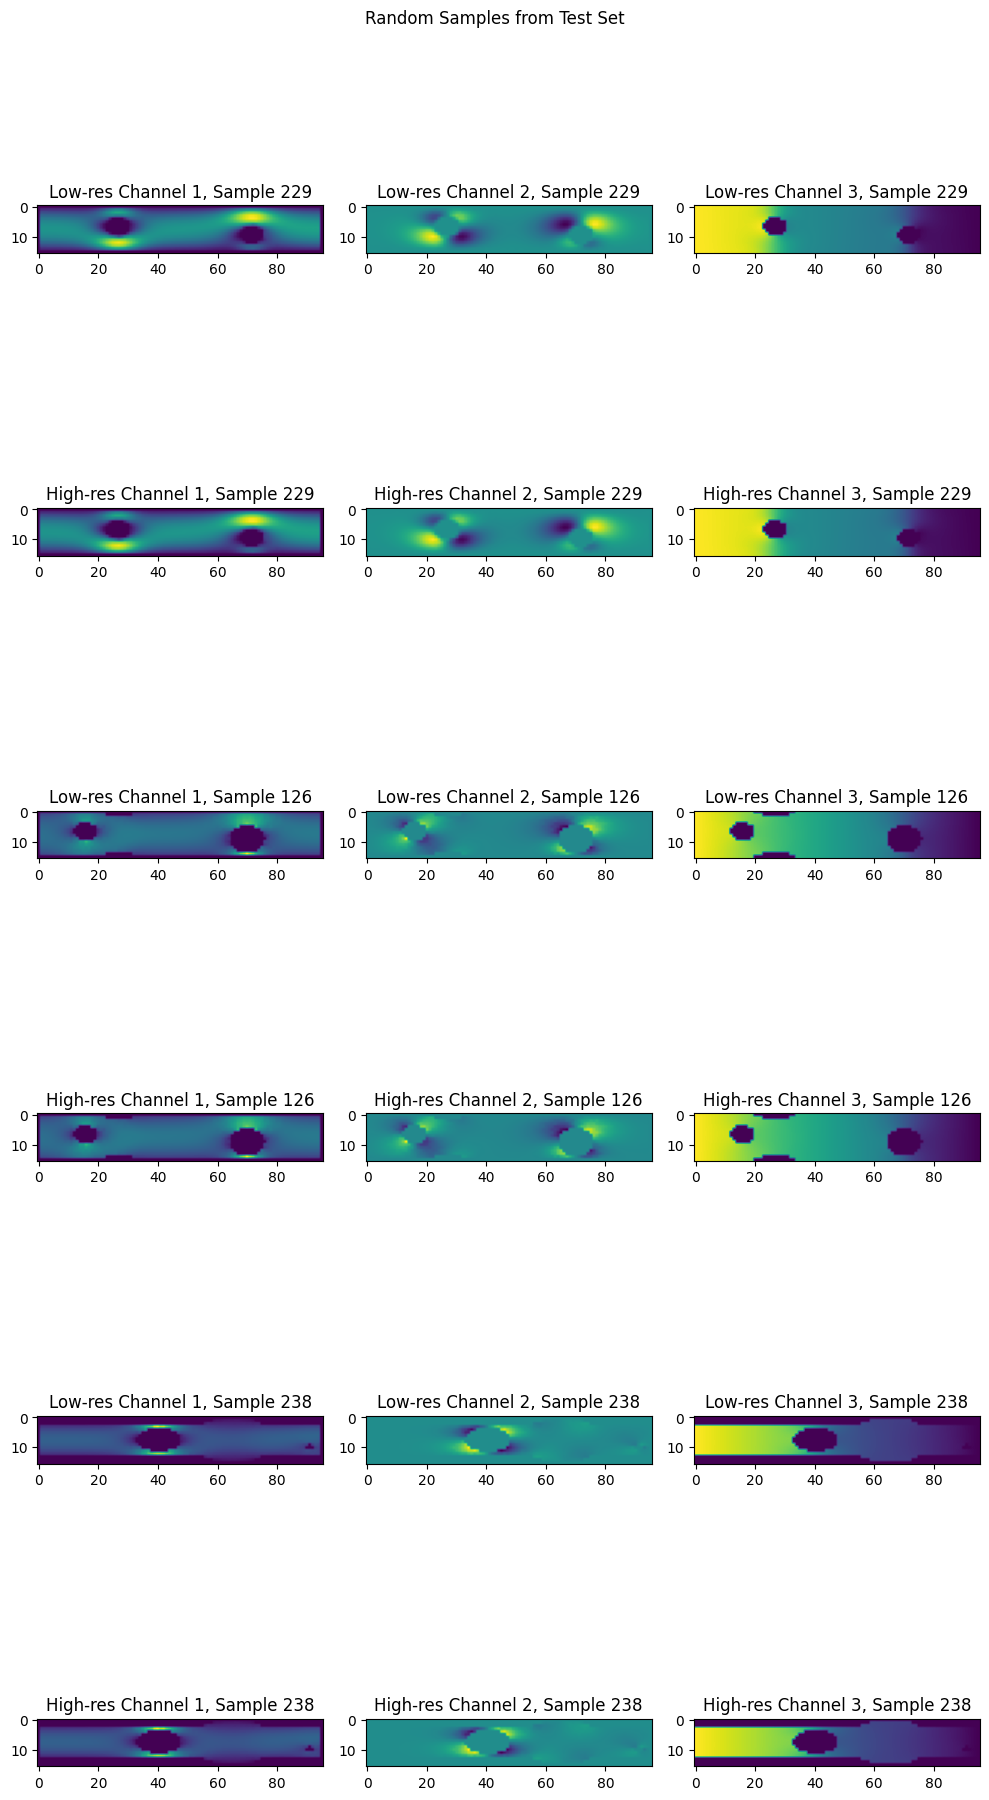

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the loaders to display images from
loaders = [train_loader, val_loader, test_loader]

# Loop over the loaders to display images from each set
for loader_idx, loader in enumerate(loaders):
    # Get a batch of data from the loader
    dataiter = iter(loader)
    low_res1, low_res2 = next(dataiter)

    # Generate random indices to select 3 samples
    idx = np.random.randint(0, low_res1.shape[0], size=3)

    # Display the input and ground truth images
    fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10, 20))
    for i in range(3):
        for j in range(3):
            # Display each channel separately for the low-resolution image
            axs[i*2, j].imshow(low_res1[idx[i]].cpu().numpy()[:,:,j])
            axs[i*2, j].set_title(f"Low-res Channel {j+1}, Sample {idx[i]+1}")

            # Display each channel separately for the high-resolution image
            axs[i*2+1, j].imshow(low_res2[idx[i]].cpu().numpy()[:,:,j])
            axs[i*2+1, j].set_title(f"High-res Channel {j+1}, Sample {idx[i]+1}")

    # Set the overall title for the plot
    fig.suptitle(f"Random Samples from {['Train', 'Val', 'Test'][loader_idx]} Set")

    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
# Define the autoencoder, loss function and optimizer
autoencoder = Autoencoder_low().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

train_tensor_x = train_tensor_x.to(device)
val_tensor_x = val_tensor_x.to(device)
test_tensor_x = test_tensor_x.to(device)


# Define the number of epochs
num_epochs = 25

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [ ]:
# Train the autoencoder
train_losses = []
val_losses = []
test_losses = []
for epoch in range(num_epochs):

    # Update the learning rate
    scheduler.step()

    train_loss = 0.0
    val_loss = 0.0
    test_loss = 0.0
    autoencoder.train()
    for data in train_loader:
        images, _ = data
        images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    autoencoder.eval()
    valid_psnrs=[]
    for data in val_loader:
        images, _ = data
        images = images.permute(0, 3, 1, 2)
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        val_loss += loss.item() * images.size(0)

        # Calculate PSNR
        psnr_value = psnr(images, outputs)
        valid_psnrs.append(psnr_value)

    
    test_psnrs = []
    for data in test_loader:
        images, _ = data
        images = images.permute(0, 3, 1, 2)
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        test_loss += loss.item() * images.size(0)

        # Calculate PSNR
        psnr_value = psnr(images, outputs)
        test_psnrs.append(psnr_value)

    # Calculate the average losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    valid_psnr = np.mean(valid_psnrs)
    test_psnr = np.mean(test_psnrs)


    # Print the losses
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, Valid PSNR: {valid_psnr:.2f}, Test PSNR: {test_psnr:.2f}')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1, Train Loss: 0.0310, Val Loss: 0.0154, Test Loss: 0.0154, Valid PSNR: 18.12, Test PSNR: 18.12
Epoch 2, Train Loss: 0.0064, Val Loss: 0.0057, Test Loss: 0.0057, Valid PSNR: 22.43, Test PSNR: 22.44
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0050, Test Loss: 0.0051, Valid PSNR: 22.97, Test PSNR: 22.97
Epoch 4, Train Loss: 0.0024, Val Loss: 0.0035, Test Loss: 0.0035, Valid PSNR: 24.59, Test PSNR: 24.57
Epoch 5, Train Loss: 0.0018, Val Loss: 0.0031, Test Loss: 0.0031, Valid PSNR: 25.03, Test PSNR: 25.03
Epoch 6, Train Loss: 0.0016, Val Loss: 0.0019, Test Loss: 0.0020, Valid PSNR: 27.10, Test PSNR: 27.08
Epoch 7, Train Loss: 0.0014, Val Loss: 0.0017, Test Loss: 0.0017, Valid PSNR: 27.61, Test PSNR: 27.63
Epoch 8, Train Loss: 0.0013, Val Loss: 0.0016, Test Loss: 0.0016, Valid PSNR: 27.85, Test PSNR: 27.87
Epoch 9, Train Loss: 0.0013, Val Loss: 0.0023, Test Loss: 0.0024, Valid PSNR: 26.29, Test PSNR: 26.29
Epoch 10, Train Loss: 0.0011, Val Loss: 0.0017, Test Loss: 0.0017, Valid PSNR: 27.

In [ ]:
# Saving the decoder

PATH = './low_encoder.ckpt'
torch.save({
        'epoch': num_epochs,
        'model_state_dict': autoencoder.encoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, PATH)


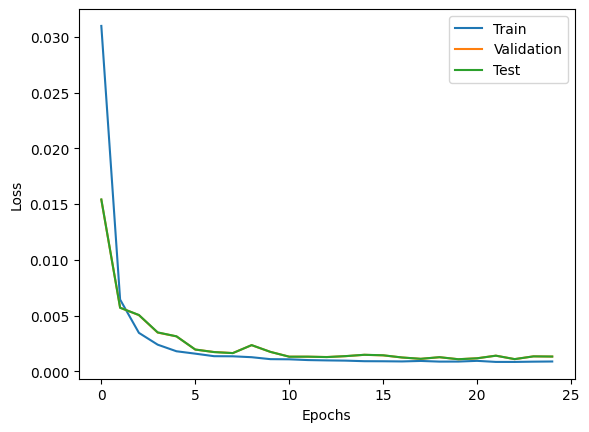

In [ ]:
# Plot the losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

(3, 16, 96, 3) (3, 16, 96, 3)


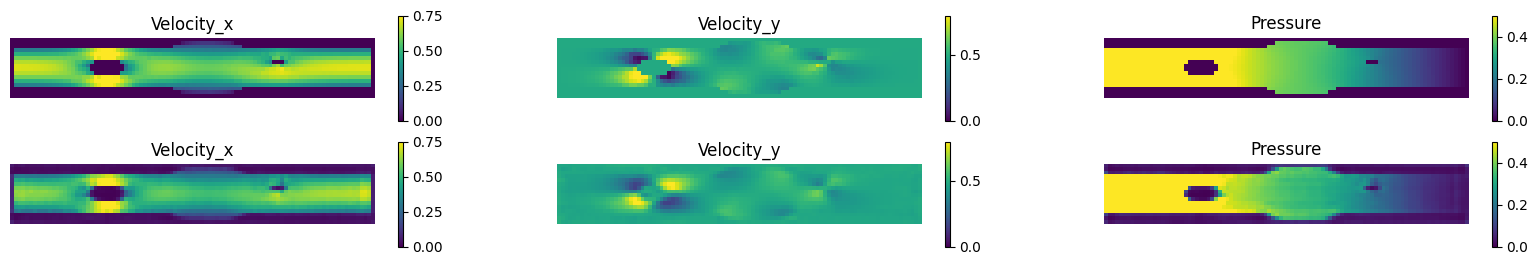

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Select 5 random images from the test set
test_images, _ = next(iter(test_loader))
indices = torch.randperm(test_images.size(0))[:3]
images = test_images[indices].to(device)
images = images.permute(0, 3, 1, 2)



# Generate reconstructions
reconstructions = autoencoder(images).detach().cpu().numpy()


single_channel_reconstructions = reconstructions.transpose(0, 2, 3, 1)
single_channel_images = images.cpu().numpy().transpose(0, 2, 3, 1)

print(single_channel_reconstructions.shape, single_channel_images.shape)

# Visualize the images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 3))
for i in range(1):
      for j in range(3):
        if j == 0:
            im = axes[i,j].imshow(single_channel_images[i,:,:,j], vmin=0, vmax=0.75)
        elif j == 1:
            im = axes[i,j].imshow(single_channel_images[i,:,:,j], vmin=0, vmax=0.8)
        elif j == 2:
            im = axes[i,j].imshow(single_channel_images[i,:,:,j], vmin=0, vmax=1.0)
          # im = axes[i,j].imshow(single_channel_images[i,:,:,j], vmin=0, vmax=1)
        axes[i,j].axis('off')
        axes[i,0].set_title('Velocity_x')
        axes[i,1].set_title('Velocity_y')
        axes[i,2].set_title('Pressure')
        # axes[i,0].set_title('Original')
        fig.colorbar(im, ax=axes[i,j])

for i in range(1):
      for j in range(3):
        if j == 0:
            im2 = axes[i+1,j].imshow(single_channel_reconstructions[i,:,:,j], vmin=0, vmax=0.75)
        elif j == 1:
            im2 = axes[i+1,j].imshow(single_channel_reconstructions[i,:,:,j], vmin=0, vmax=0.8)
        elif j == 2:
            im2 = axes[i+1,j].imshow(single_channel_reconstructions[i,:,:,j], vmin=0, vmax=1.0)
        axes[i+1,j].axis('off')
        axes[i+1,0].set_title('Velocity_x')
        axes[i+1,1].set_title('Velocity_y')
        axes[i+1,2].set_title('Pressure')
        fig.colorbar(im2, ax=axes[i+1,j])

plt.show()
